# ОБУЧЕНИЕ СВЕРТОЧНЫХ СЕТЕЙ ПО РЕГРЕССИИ EF НА ОСНОВЕ ИЗОБРАЖЕНИЙ ПРОЕКЦИЙ ВЭКГ

 ### Как запустить сервер MLflow:

```
mlflow server --backend-store-uri "file:///C:/ML_flow_server" --host localhost --port 5000
```
По этой ссылке будет доступен MLflow: http://localhost:5000

In [1]:
import os
import random
from func import *

from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset, ConcatDataset
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
import cv2
import torch
import mlflow
from PIL import Image
import seaborn as sns
import numpy as np # библиотека работы с матрицами на цпу
import torch.nn as nn # модуль библиотеки для создрания слоев 
import matplotlib.pyplot as plt # библиотека для отображения графиков и изображений
import torchvision
from torchvision import transforms, datasets
from tqdm import tqdm
import torchvision.models as models
from torchvision.transforms.functional import normalize

from torchvision.transforms import functional as F

import warnings

import mlflow.pytorch
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline

In [2]:
# Инициализация MLflow
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("VECG_CNN_Regression")

<Experiment: artifact_location='mlflow-artifacts:/154255156360409039', creation_time=1693231219212, experiment_id='154255156360409039', last_update_time=1693231219212, lifecycle_stage='active', name='VECG_CNN_Regression', tags={}>

In [3]:
 # Установка Seed для воспроизводимости
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [4]:
# КОНСТАНТЫ:
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# Путь к корневой папке датасета
DATASET_PATH = "final_img_dataset"

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## ПРЕПОДГОТОВКА ДАННЫХ:

In [5]:
class ImageDataset(Dataset):
    def __init__(self, root, subset_type, transform=None):

        self.df_gt = pd.read_csv(f"{root}/{subset_type}/ground_truth.csv", index_col=0)

        self.image_paths = glob(f"{root}/{subset_type}/*.png")
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]

        img = Image.open(img_path)
        img = img.resize((IMG_WIDTH, IMG_HEIGHT)) 

        if self.transform is not None:
            img = self.transform(img)
        
        target = self.df_gt.loc[os.path.basename(img_path)]['EF'] 

        return img, torch.tensor([target]).to(torch.float64)

In [6]:
# Преобразования изображений
transform_train = transforms.Compose([transforms.ToTensor(),])
transform_val = transforms.Compose([transforms.ToTensor(),])

ds_train = ImageDataset(DATASET_PATH, "train", transform=transform_train)
ds_val = ImageDataset(DATASET_PATH, "val", transform=transform_val)

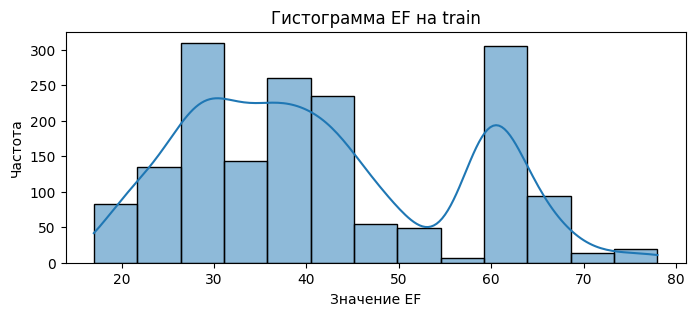

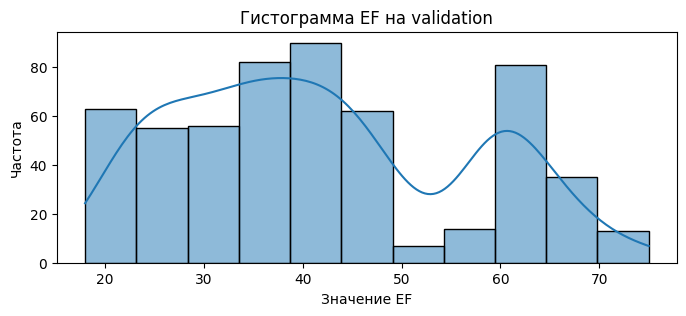

In [7]:
plt.figure(figsize=(8, 3))  
sns.histplot(data=ds_train.df_gt, x='EF', kde=True)
plt.title('Гистограмма EF на train')
plt.xlabel('Значение EF')
plt.ylabel('Частота')
plt.show()

plt.figure(figsize=(8, 3))  
sns.histplot(data=ds_val.df_gt, x='EF', kde=True)
plt.title('Гистограмма EF на validation')
plt.xlabel('Значение EF')
plt.ylabel('Частота')
plt.show()


In [8]:
# Создание обучающего и валидационного загрузчиков данных
train_loader = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(ds_val, batch_size=BATCH_SIZE)

Пример тренировочного батча:


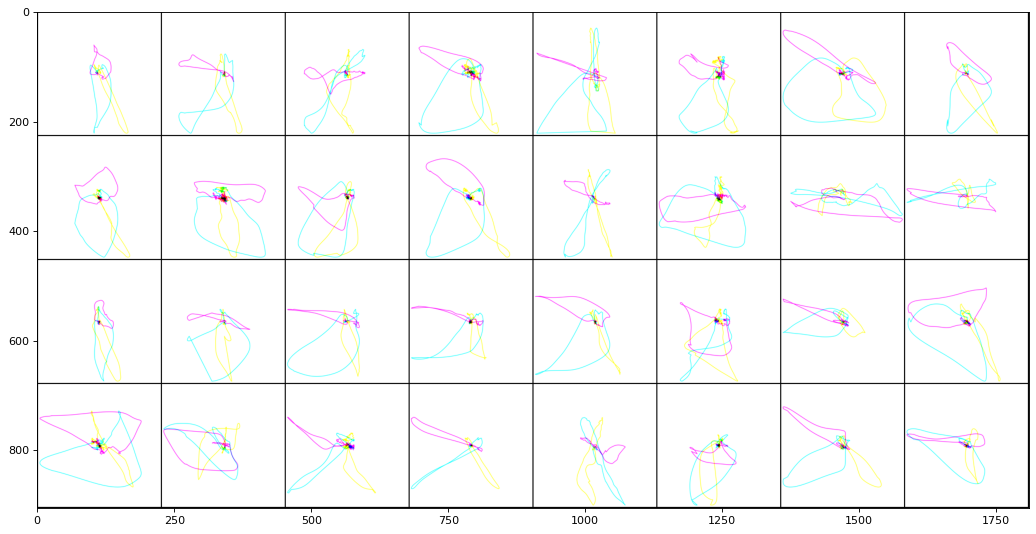

GroundTruth:  43.0,  31.0,  28.0,  60.0,  39.0,  38.0,  60.0,  20.0,  48.0,  45.0,  41.0,  45.0,  45.0,  34.0,  29.0,  32.0,  34.0,  43.0,  25.0,  45.0,  30.0,  47.0,  60.0,  62.0,  60.0,  74.0,  68.0,  21.0,  37.0,  21.0,  60.0,  65.0


In [9]:

print('Пример тренировочного батча:')
image_batch, label_batch = next(iter(train_loader))
image_batch, label_batch = image_batch.to(device), label_batch.to(device)

plt.figure(figsize=(16, 10), dpi=80)
# выводим изображения в батче
imshow(torchvision.utils.make_grid(image_batch, nrow=8))
print('GroundTruth: ', ',  '.join(str(label_batch[j].item()) for j in range(BATCH_SIZE)))

## ОБУЧЕНИЕ СЕТЕЙ:

In [10]:
# Определение количества итераций в одной эпохе
iterations_per_epoch = len(train_loader)
print('Число градиентных спусков за 1 эпоху раняется', iterations_per_epoch)

Число градиентных спусков за 1 эпоху раняется 54


### 1. Неглубокая сеть собственного сочинения:

In [11]:
class SimpleConvRegNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(
            in_channels=3, out_channels=6, kernel_size=3, padding=1)   #224:224 -размер изображения на выходе 
        self.act1 = torch.nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)       #112:112
        
        self.conv2 = torch.nn.Conv2d(
            in_channels=6, out_channels=10, kernel_size=3, padding=1)  #112:112
        self.act2 = torch.nn.ReLU()
        self.pool2 = torch.nn.MaxPool2d(kernel_size=4, stride=4) #28:28
        
        self.conv3 = torch.nn.Conv2d(
            in_channels=10, out_channels=10, kernel_size=3, padding=1) #28:28
        self.act3 = torch.nn.ReLU()
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2) #14:14
        
        self.conv4 = torch.nn.Conv2d(
            in_channels=10, out_channels=5, kernel_size=3, padding=1) #14:14
        self.act4 = torch.nn.ReLU()


        self.fc1   = torch.nn.Linear(14 * 14 * 5, 50)
        self.act5 = torch.nn.ReLU()

        self.fc2   = torch.nn.Linear(50, 30)
        self.act6 = torch.nn.ReLU()

        self.fc3   = torch.nn.Linear(30, 1)

        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.act1(x)  
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.act3(x)
        x = self.pool3(x)
        
        x = self.conv4(x)
        x = self.act4(x)
          
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act5(x)
        
        x = self.fc2(x)
        x = self.act6(x)
        
        x = self.fc3(x)
        
        return x

Опорная метрика лучшего результата валидации для сохранения - __MSE__ <br/>
Так же будем трекать метрику MAE

In [12]:
train_regressor(model_CNN=SimpleConvRegNet, dataloader_train=train_loader,
                 dataloader_val=val_loader, batch_size=BATCH_SIZE, start_weight=None,
                 name_save='custom_train_g05', mlflow_tracking=True,
                 name_experiment='Own composition CNN training gamma=0.5', gamma=0.5,
                 lr=1e-3, epochs=35, scheduler=True, scheduler_step_size=5, dataset_name=DATASET_PATH)

С MLFLOW


In [ ]:
train_regressor(model_CNN=SimpleConvRegNet, dataloader_train=train_loader,
                 dataloader_val=val_loader, batch_size=BATCH_SIZE, start_weight=None,
                 name_save='custom_train_no_sheduler', mlflow_tracking=True,
                 name_experiment='Own composition CNN training no scheduler',
                 lr=1e-3, epochs=35, scheduler=False, dataset_name=DATASET_PATH)

### 2. Архитектура ResNet18:

In [ ]:
train_regressor(model_CNN='resnet18', dataloader_train=train_loader,
                 dataloader_val=val_loader, batch_size=BATCH_SIZE, start_weight=None,
                 name_save='resnet_train_5', mlflow_tracking=True,
                 name_experiment='ResNet18 scheduler_step_size=5', gamma=0.5,
                 lr=1e-3, epochs=35, scheduler=True, scheduler_step_size=5, dataset_name=DATASET_PATH, n_neurons=0)

__fine_tune:__

In [ ]:
train_regressor(model_CNN='resnet18', dataloader_train=train_loader,
                 dataloader_val=val_loader, batch_size=BATCH_SIZE, start_weight=True,
                 name_save='resnet_train_ft_5', mlflow_tracking=True,
                 name_experiment='Fine tuned ResNet18 scheduler_step_size=5', gamma=0.5,
                 lr=1e-3, epochs=35, scheduler=True, scheduler_step_size=5, dataset_name=DATASET_PATH, n_neurons=0)

In [ ]:
train_regressor(model_CNN='resnet18', dataloader_train=train_loader,
                 dataloader_val=val_loader, batch_size=BATCH_SIZE, start_weight=True,
                 name_save='resnet_train_ft_no_sheduler', mlflow_tracking=True,
                 name_experiment='Fine tuned ResNet18 no scheduler', gamma=0.5,
                 lr=1e-3, epochs=35, scheduler=False, scheduler_step_size=3, dataset_name=DATASET_PATH, n_neurons=0)

Увеличим размер батча (с 32 до 64):

In [ ]:
# Создание обучающего и валидационного загрузчиков данных
BATCH_SIZE = 64
train_loader = DataLoader(ds_train, batch_size=64, shuffle=True)
val_loader = DataLoader(ds_val, batch_size=64)

In [ ]:
# Определение количества итераций в одной эпохе
iterations_per_epoch = len(train_loader)
print('Число градиентных спусков за 1 эпоху раняется', iterations_per_epoch)

In [ ]:
train_regressor(model_CNN='resnet18', dataloader_train=train_loader,
                 dataloader_val=val_loader, batch_size=BATCH_SIZE, start_weight=True,
                 name_save='resnet_train_ft_no_sheduler_batch64', mlflow_tracking=True,
                 name_experiment='Fine tuned ResNet18 batch=64 no_sheduler',
                 lr=1e-3, epochs=40, scheduler=False, dataset_name=DATASET_PATH, n_neurons=0)